In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import gtsam
from gtsam import Pose2
import gtsam.utils.plot as gtsam_plot
import cv2
import import_ipynb
from Image_Registration_Part_1 import * ## Import functions from my code of Part-1 to use here
import os
import random
from scipy.optimize import least_squares
import itertools

### Step-1: Image Preprocessing and Normalization

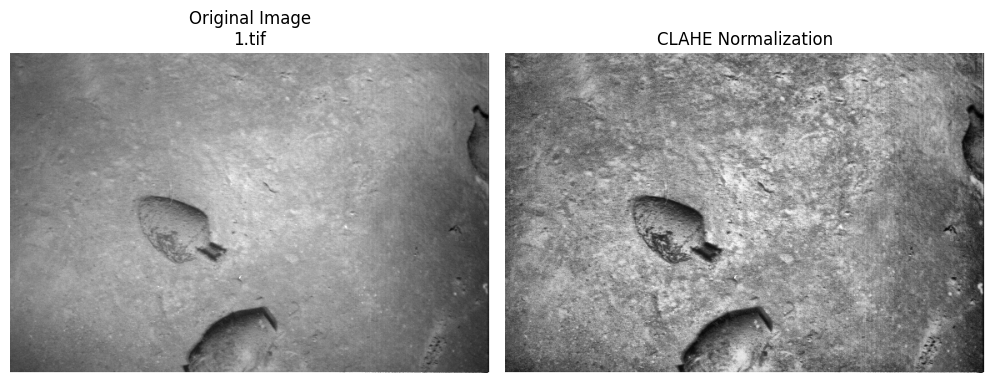

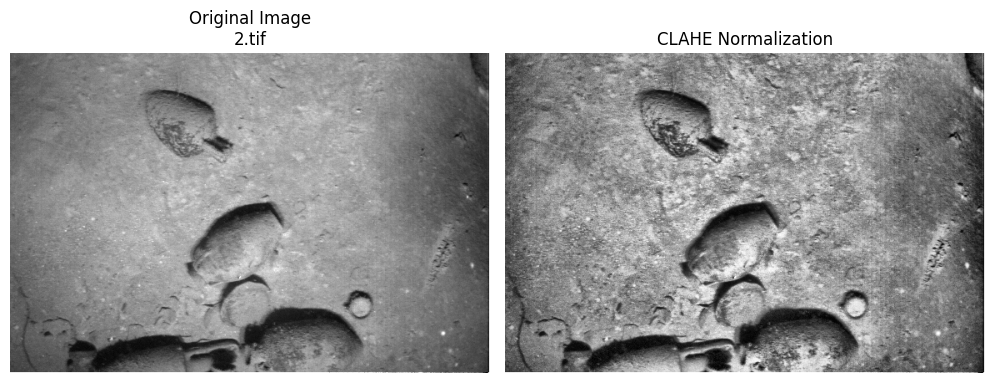

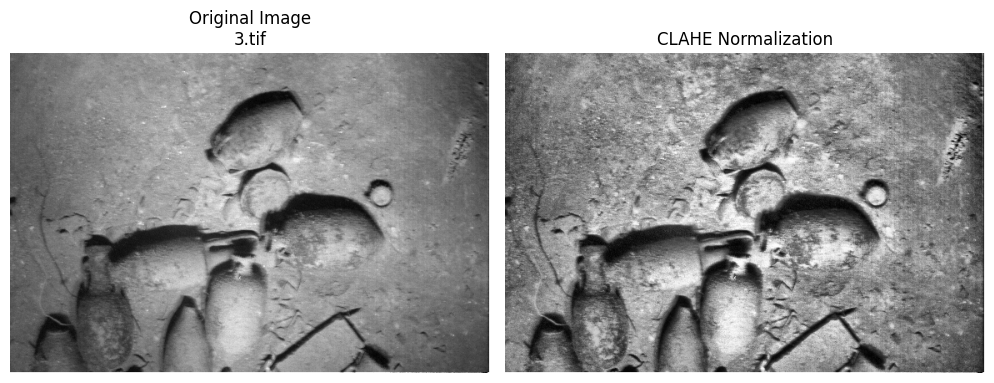

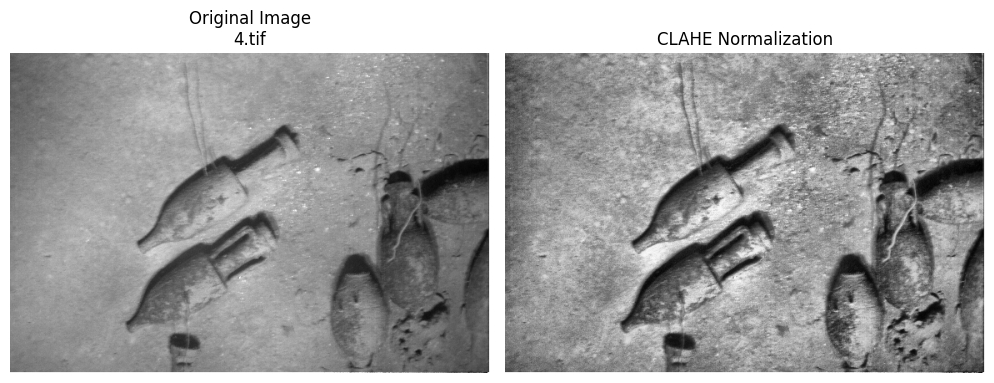

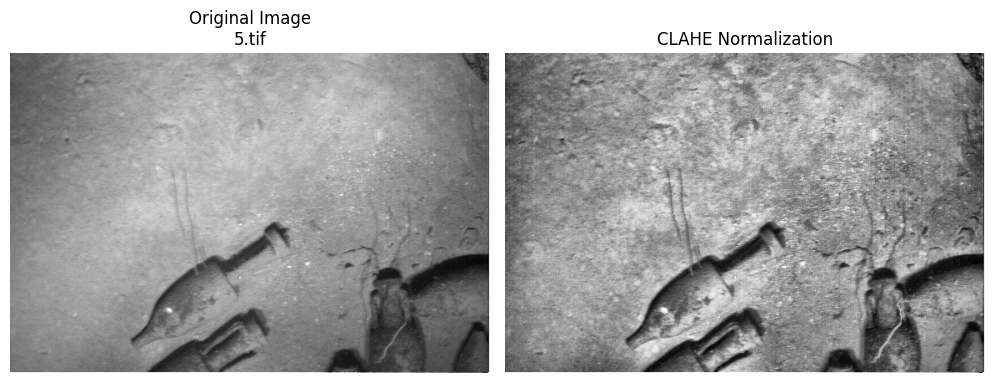

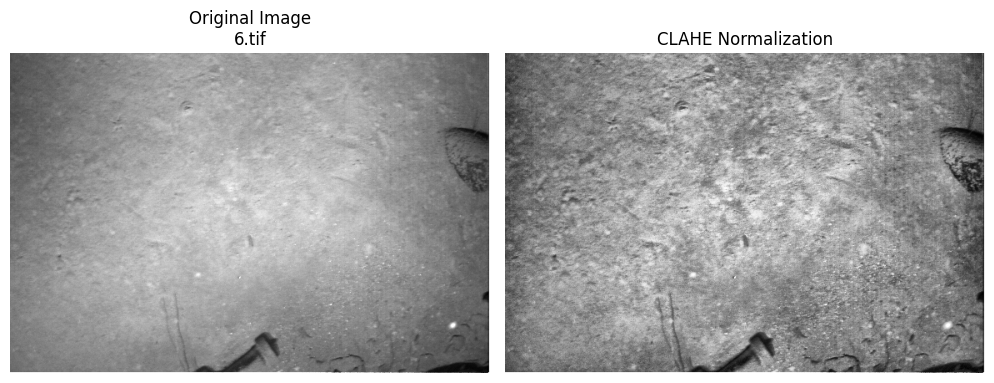

In [4]:
# Replace with the path to your folder containing images
folder_path = '6Images'
images = load_images_from_folder(folder_path)

# Process and plot each image
for filename, image in images:
    clahe_image, normalized_image = normalize_image(image)
    plot_images(image, clahe_image, title=filename)

### Step-2: SIFT: Extracting Keypoints and Descriptors

Detected 5000 keypoints.


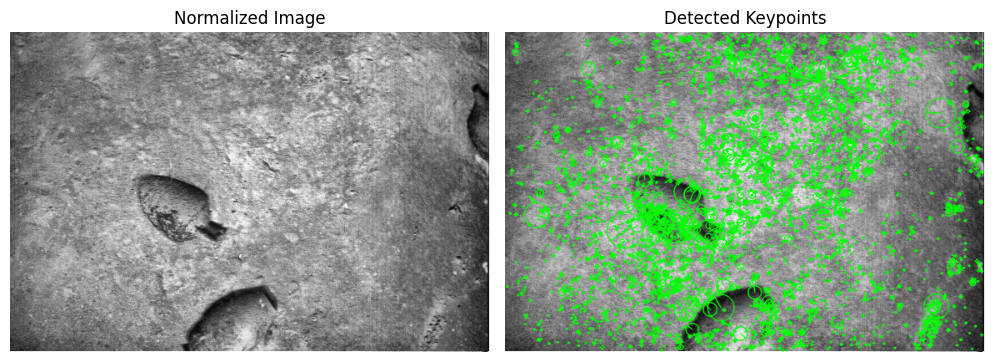

Detected 5000 keypoints.


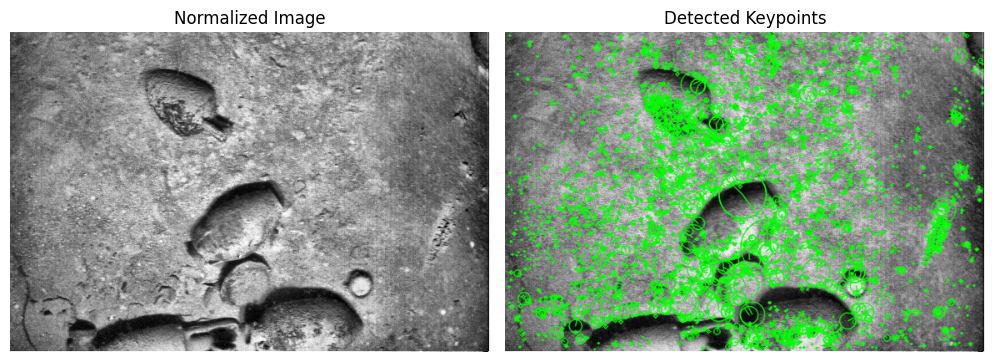

Detected 5000 keypoints.


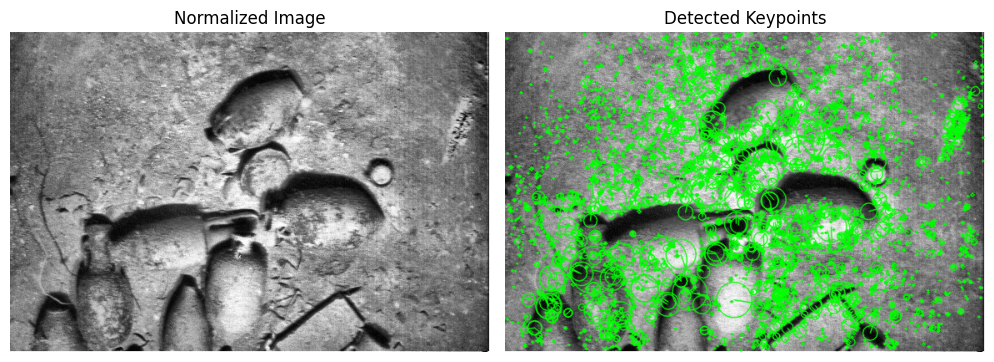

Detected 5001 keypoints.


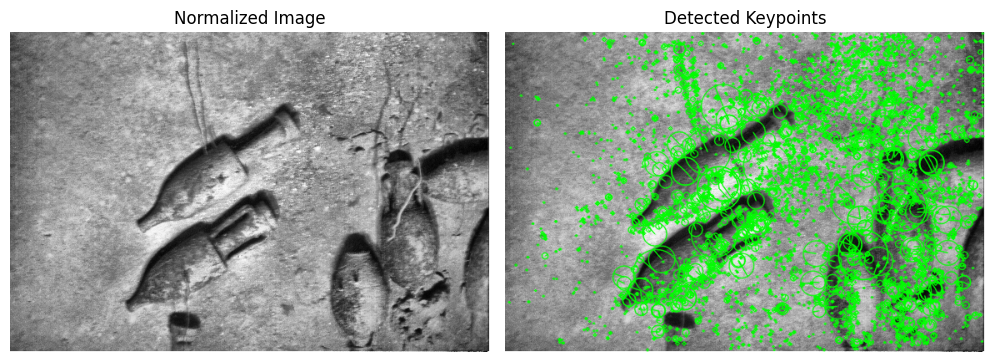

Detected 5000 keypoints.


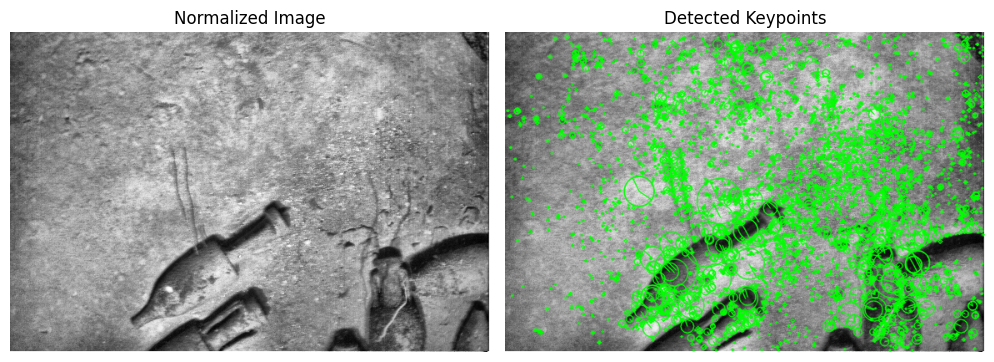

Detected 5000 keypoints.


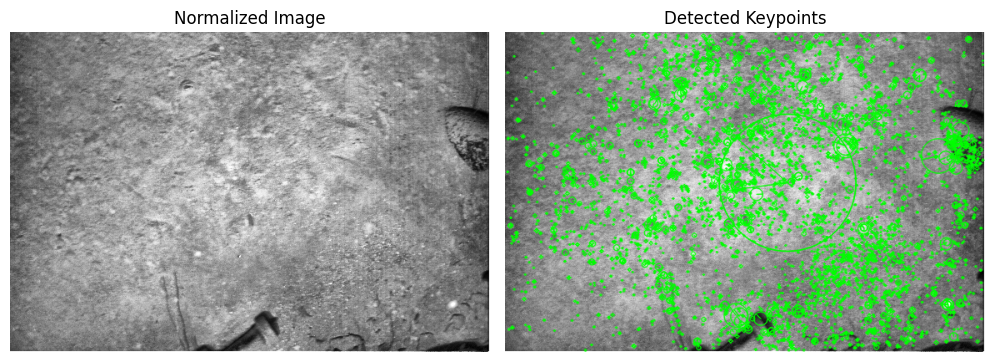

In [5]:
# Set seeds for reproducibility
np.random.seed(42)  # Seed for NumPy operations
cv2.setRNGSeed(42)  # Seed for OpenCV operations
random.seed(42)     # Seed for Python random operations

keypoint_store = []
descriptor_store = []

normalized = []
pixel = []

# Process and plot each image
for filename, image in images:
    
    clahe_image, normalized_image = normalize_image(image) 
    normalized.append(clahe_image)
    pixel.append(normalized_image)   

    # Detect and describe features on the normalized image
    keypoints, descriptors = detect_and_describe_features(clahe_image)

    keypoint_store.append(np.array(keypoints))
    descriptor_store.append(np.array(descriptors))
    
    # Plot the normalized image and the keypoints
    plot_keypoint(clahe_image, keypoints)

### Step-3: Feature Matching using FLANN

Found 545 good matches.
Processed Image 0, Matching with 1: Found 545 matches.
Found 501 good matches.
Processed Image 1, Matching with 2: Found 501 matches.
Found 50 good matches.
Processed Image 2, Matching with 3: Found 50 matches.
Found 565 good matches.
Processed Image 3, Matching with 4: Found 565 matches.
Found 403 good matches.
Processed Image 4, Matching with 5: Found 403 matches.
Found 50 good matches.
Processed Image 5, Matching with 0: Found 50 matches.
Found 62 good matches.


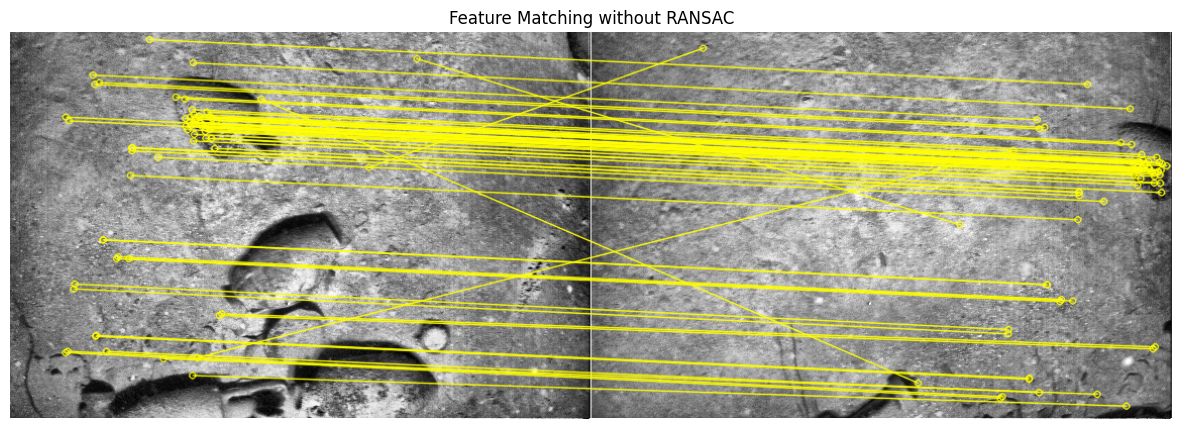

In [6]:
# Match features between the two images
collected_matches = match_keypoints_across_images(keypoint_store, descriptor_store)

# # Plot the matching results
im1=1
im2=5

good_matches, (src, dst) = match_features(descriptor_store[im1], descriptor_store[im2], keypoint_store[im1], keypoint_store[im2])
plot_matching_results(im1, im2, normalized, keypoint_store, good_matches)

### Step-4: GTSAM Noise Model and Affine Transformation Calculations

In the code, the covariance matrix for each edge is computed in the compute_transformation_and_uncertainty function. The covariance is based on the number of inliers (matched points) between two images. The uncertainty decreases as the number of inliers increases, which makes sense because more matched points generally lead to more reliable transformations.

In [7]:
def extract_pose_and_verify_distance(pose_a, pose_b, transformation=None, distance_threshold=None):
    """
    Extracts a GTSAM pose from a transformation matrix and checks if two poses are within a certain distance.
    """
    computed_pose = None
    if transformation is not None:
        angle = np.arctan2(transformation[1, 0], transformation[0, 0])
        computed_pose = gtsam.Pose2(transformation[0, 2], transformation[1, 2], angle)

    if distance_threshold is not None and pose_a is not None and pose_b is not None:
        distance = cv2.norm(pose_a.translation() - pose_b.translation())
        is_within_distance = distance < distance_threshold
        return is_within_distance, computed_pose

    return computed_pose

def compute_transformation_and_uncertainty(src_points, dst_points): ##REFERENCE TAKEN FROM ZHIYONG ZHANG'S CODE
    """
    Computes the affine transformation between two sets of points and estimates the uncertainty.
    """
    if src_points.shape[0] < 4:
        return None

    affine_transform, inlier_mask = cv2.estimateAffinePartial2D(src_points, dst_points)
    num_inliers = np.sum(inlier_mask)

    if num_inliers < 3:
        return None

    scale = np.linalg.norm(affine_transform[:2, 0])
    affine_transform[:2, :2] /= scale

    sigma_values = 1000 * (num_inliers ** -2) * np.array([1, 1, np.deg2rad(1)])
    noise_model = gtsam.noiseModel.Diagonal.Sigmas(sigma_values)

    homogeneous_transform = np.vstack([affine_transform, [0, 0, 1]])
    inverse_transform = np.linalg.inv(homogeneous_transform)

    return inverse_transform, noise_model

### Step-5: GTSAM Factor Graph Construction

In [8]:
def build_factor_graph(initial_poses, images, descriptors, keypoints, img_width, img_height, initial_noise_model): ##REFERENCE TAKEN FROM ZHIYONG ZHANG'S CODE
    """
    Constructs the factor graph for pose estimation using GTSAM.
    """
    graph = gtsam.NonlinearFactorGraph()
    prior_pose = gtsam.Pose2(img_width / 2, img_height / 2, 0)
    graph.add(gtsam.PriorFactorPose2(0, prior_pose, initial_noise_model))

    image_indices = range(len(images))
    for idx_i, idx_j in itertools.combinations(image_indices, 2):
        if idx_j == idx_i + 1:
            _, (src_pts, dst_pts) = match_features(
                descriptors[idx_i], descriptors[idx_j], keypoints[idx_i], keypoints[idx_j]
            )
            transform_and_noise = compute_transformation_and_uncertainty(src_pts, dst_pts)
            if transform_and_noise:
                pose = extract_pose_and_verify_distance(None, None, transformation=transform_and_noise[0])
                graph.add(gtsam.BetweenFactorPose2(idx_i, idx_j, pose, transform_and_noise[1]))
        else:
            is_within_range, _ = extract_pose_and_verify_distance(
                initial_poses.atPose2(idx_i),
                initial_poses.atPose2(idx_j),
                distance_threshold=img_width * 0.8
            )
            if is_within_range:
                _, (src_pts, dst_pts) = match_features(
                    descriptors[idx_i], descriptors[idx_j], keypoints[idx_i], keypoints[idx_j]
                )
                transform_and_noise = compute_transformation_and_uncertainty(src_pts, dst_pts)
                if transform_and_noise:
                    pose = extract_pose_and_verify_distance(None, None, transformation=transform_and_noise[0])
                    graph.add(gtsam.BetweenFactorPose2(idx_i, idx_j, pose, transform_and_noise[1]))
    return graph

def display_graph(estimated_poses, factor_graph, covariance_estimates):
    """
    Visualizes the factor graph and the estimated poses.
    """
    for idx in range(estimated_poses.size()):
        pose = estimated_poses.atPose2(idx)
        covariance = covariance_estimates.marginalCovariance(idx)
        gtsam.utils.plot.plot_pose2(0, pose, 0.5, covariance)

    for factor_idx in range(1, factor_graph.size()):
        factor = factor_graph.at(factor_idx)
        key1, key2 = factor.keys()
        pose1 = estimated_poses.atPose2(key1)
        pose2 = estimated_poses.atPose2(key2)
        plt.plot([pose1.x(), pose2.x()], [pose1.y(), pose2.y()], 'b-')

    plt.show()

In [13]:
def stitch_panorama(image_list, transform_list, canvas_size=(3000, 3000)):
    """
    Creates a panorama by stitching multiple images using the provided transformations.
    """
    canvas = np.zeros((canvas_size[0], canvas_size[1], 3), dtype=np.uint8)
    shift_center = np.array([
        [1, 0, canvas_size[0] / 2],
        [0, 1, canvas_size[1] / 2],
        [0, 0, 1]
    ])

    for image, transform in zip(image_list, transform_list):
        warped_image = cv2.warpPerspective(image, shift_center @ transform, canvas_size)
        canvas = np.maximum(canvas, warped_image)

    # Trim the canvas to the actual content
    non_zero_mask = np.any(canvas != 0, axis=2)
    non_zero_coords = np.argwhere(non_zero_mask)
    if non_zero_coords.size == 0:
        return None
    top_left = non_zero_coords.min(axis=0)
    bottom_right = non_zero_coords.max(axis=0)
    y_start, x_start = top_left
    y_end, x_end = bottom_right

    return canvas[y_start:y_end+1, x_start:x_end+1]

### Step-6: Factor Graph before Levenberg Marquadt Optimization

In the code, the covariance matrix for each edge in the factor graph is defined by the noiseModel.Diagonal.Sigmas() function, which takes standard deviations for x, y, and yaw as input.

1. The standard deviations for the x and y translation components are 5 units, representing the uncertainty in image positioning along the x and y axes.

2. The standard deviation for yaw (rotation) is 5 degrees, which corresponds to np.deg2rad(5) radians.

Justification for Initial Uncertainty Values:

1. Translation (5 units): The value of 5 units for translation uncertainty is a reasonable default when dealing with large image sets where image registration might involve some noise or error. It's large enough to allow the optimization process to make necessary corrections but not too large, as this would reduce confidence in the initial pose estimates.

2. Rotation (5 degrees): A 5-degree uncertainty in the rotation is chosen to allow for slight misalignment in the orientation of images. This provides flexibility during the optimization process, enabling it to refine the rotations between images without large, unmanageable changes.

The covariance matrix defines how uncertain we are about the transformation between two images. It directly affects how much freedom the optimizer has to adjust the relative positions and orientations of the images. Lower covariance values (tighter constraints) mean we are confident in the transformation, while higher values allow more adjustment. By setting a covariance matrix with relatively loose constraints, we are acknowledging the inherent uncertainty in the initial pose estimates and allowing the optimization process (Levenberg-Marquardt) to correct these estimates.

Found 545 good matches.
Found 501 good matches.
Found 50 good matches.
Found 565 good matches.
Found 403 good matches.
Found 545 good matches.
Found 98 good matches.
Found 8 good matches.
Found 51 good matches.
Found 501 good matches.
Found 14 good matches.
Found 39 good matches.
Found 62 good matches.
Found 50 good matches.
Found 27 good matches.
Found 16 good matches.
Found 565 good matches.
Found 105 good matches.
Found 403 good matches.


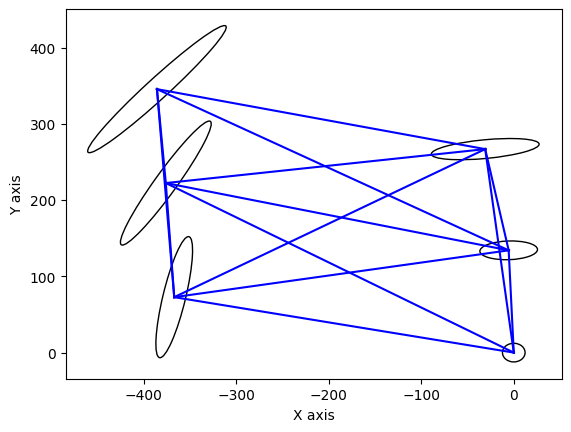

In [10]:
# Initial uncertainty model
initial_uncertainty = gtsam.noiseModel.Diagonal.Sigmas(np.array([5, 5, np.deg2rad(5)]))
initial_estimates = gtsam.Values()

# Get image dimensions
img_width, img_height = pixel[0].shape[1], pixel[0].shape[0]

# Initialize cumulative transformation and initial pose
cumulative_transform = np.eye(3)
initial_estimates.insert(0, gtsam.Pose2())

# Build initial estimates for poses
for i in range(len(pixel) - 1):
    # Match features between consecutive images
    _, (origin_pts, target_pts) = match_features(
        descriptor_store[i],
        descriptor_store[i + 1],
        keypoint_store[i],
        keypoint_store[i + 1]
    )
    # Compute transformation and uncertainty
    transform, _ = compute_transformation_and_uncertainty(origin_pts, target_pts)
    if transform is None:
        continue  # Skip if transformation could not be computed
    # Update cumulative transformation
    cumulative_transform = transform @ cumulative_transform
    # Extract pose from cumulative transformation
    extracted_pose = extract_pose_and_verify_distance(None, None, transformation=cumulative_transform)
    initial_estimates.insert(i + 1, extracted_pose)

# Build the factor graph using the updated function
factor_graph = build_factor_graph(
    initial_poses=initial_estimates,
    images=pixel,
    descriptors=descriptor_store,
    keypoints=keypoint_store,
    img_width=img_width,
    img_height=img_height,
    initial_noise_model=initial_uncertainty
)

# Compute marginals for initial estimates
uncertainties = gtsam.Marginals(factor_graph, initial_estimates)

# Visualize the initial graph
display_graph(initial_estimates, factor_graph, uncertainties)

### Step-7: Factor Graph after Levenberg Marquadt Optimization

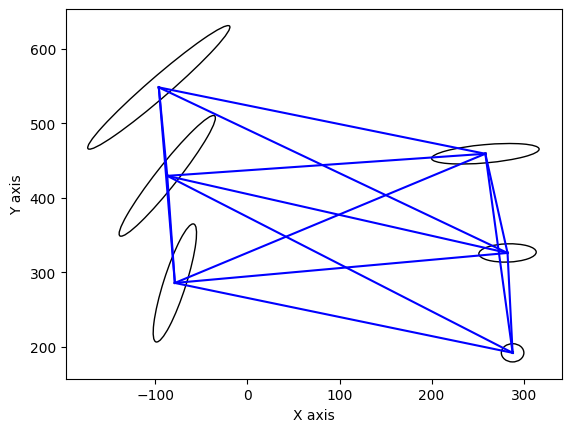

In [11]:
# Optimize the factor graph
optimization_params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(factor_graph, initial_estimates, optimization_params)
optimized_estimates = optimizer.optimize()

# Calculate marginals for uncertainty estimation after optimization
marginals = gtsam.Marginals(factor_graph, optimized_estimates)

# Visualize the optimized graph
display_graph(optimized_estimates, factor_graph, marginals)

Effect on odometry (image centre location) and covariance (ellipses in the factor graph around the image centre) before and after Optimization:

1. The general shape of the graph is maintained, indicating that the optimization didn't drastically alter the relative positions of the images. However, there are noticeable changes in the absolute positions and orientations of the image centers.

2. The optimized graph (Image 2) appears to be scaled up and shifted compared to the initial graph (Image 1). The x-axis range changed from approximately [-400, 0] to [-100, 300], indicating a significant shift and scale change. The y-axis range increased from about [0, 400] to [200, 600], showing both a shift and scale increase.

3. The ellipses representing pose uncertainties appear to have changed slightly in size and orientation, generally becoming smaller, which suggests reduced uncertainty after optimization. The relative positions of image centers have been adjusted, with some connections between nodes becoming straighter or changing in length.

4. The optimized graph looks more consistent, with smoother transitions between connected poses. This suggests that the optimization process has helped to resolve inconsistencies in the initial odometry estimates.

### Step-8: Final Mosaic

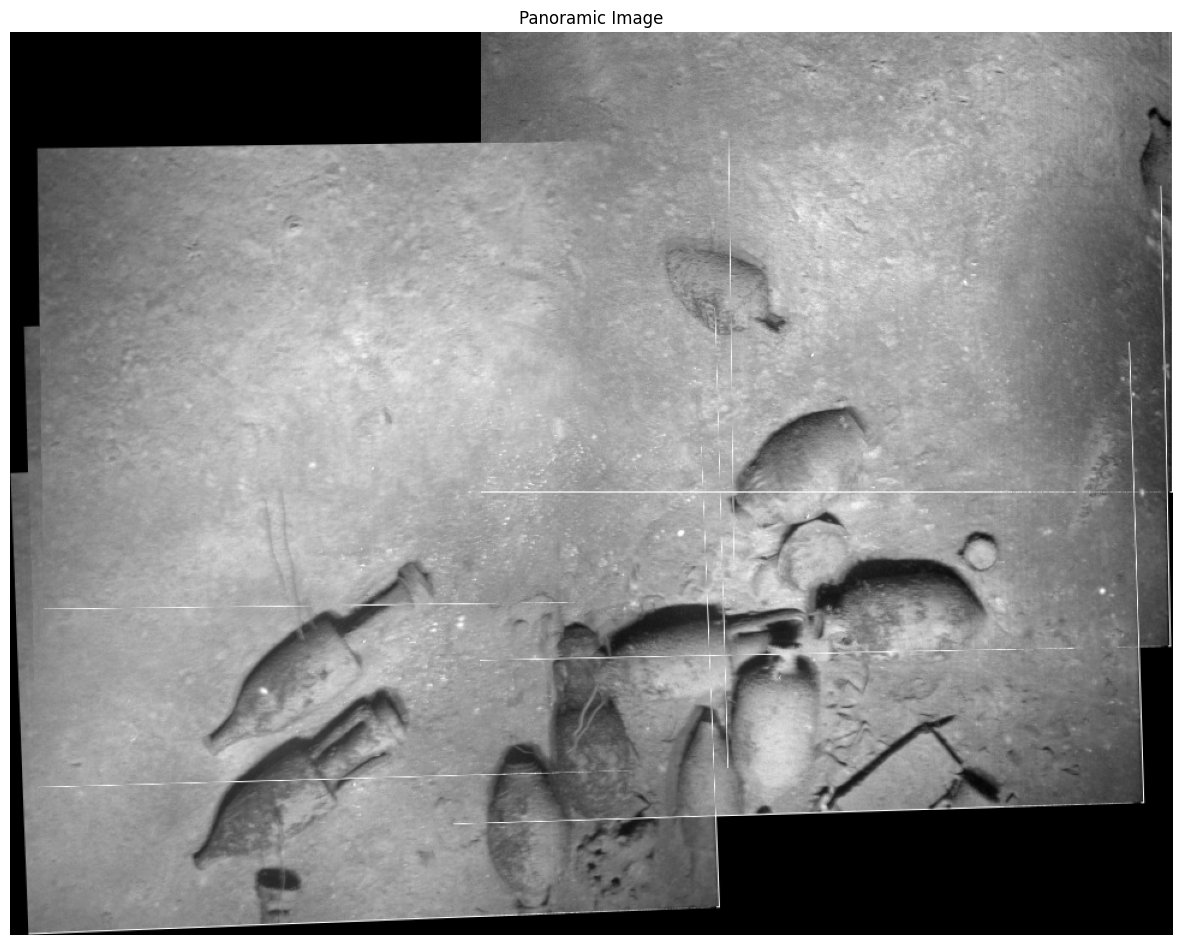

In [14]:
# Extract poses from optimized estimates
optimized_poses = gtsam.utilities.allPose2s(optimized_estimates)

# Calculate affine transformation matrices from optimized poses
affine_matrices = []
for i in range(len(pixel)):
    pose = optimized_poses.atPose2(i)
    affine_matrix = pose.matrix()
    
    # Create a translation matrix to center the image
    center_translation = np.eye(3)
    center_translation[:2, 2] = -np.array([img_width / 2, img_height / 2])
    
    # Combine affine matrix with center translation
    affine_matrices.append(affine_matrix @ center_translation)

# Create the panorama using the updated function
panorama = stitch_panorama(pixel, affine_matrices)

# Display the result
plt.figure(figsize=(15, 15))
plt.imshow(panorama)
plt.title('Panoramic Image')
plt.axis('off')
plt.show()

**The Final Stitch from GTSAM Optimization looks much better than the one created in Part-1 which was just using Homography and RANSAC. The blending could be improved here because of the visible edges and seams.**